# Data Preparation

## Make Dataset

Data from https://nrc-digital-repository.canada.ca/eng/view/object/?id=1343ae23-cebf-45c6-94c3-ddebdb2f23c6

Paper: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.042113

In [1]:
import torch
from Data.quantum_dataset import QuantumDataset

torch.cuda.empty_cache()
potential_type = 'all'
dset = QuantumDataset(potential_type)
files = dset.get_files()

C:\Users\jonah\PycharmProjects\WavefunctionCNN\Data
C:\Users\jonah\PycharmProjects\WavefunctionCNN\Data\SAMPLE
HO_gen2_0010.h5
calculated_energy: (5000, 1)
cx: (5000, 1)
cy: (5000, 1)
kx: (5000, 1)
ky: (5000, 1)
potential: (5000, 1, 256, 256)
psi: (5000, 1, 256, 256)
theoretical_energy: (5000, 1)

IW_gen2_0010.h5
calculated_energy: (5000, 1)
cx: (5000, 1)
cy: (5000, 1)
eigenvalues: (5000, 5)
potential: (5000, 1, 256, 256)
theoretical_energy: (5000, 1)
wavefunction: (5000, 1, 256, 256)
wx: (5000, 1)
wy: (5000, 1)

NG_gen2b_0000.h5
calculated_energy: (5000, 1)
eigenvalues: (5000, 5)
parameters: (5000, 10)
potential: (5000, 1, 256, 256)
wavefunction: (5000, 1, 256, 256)

RND_0011.h5
calculated_energy: (5000, 1)
eigenvalues: (5000, 5)
potential: (5000, 1, 256, 256)
wavefunction: (5000, 1, 256, 256)

RND_KE_gen2_0010.h5
calculated_energy: (5000, 1)
eigenvalues: (5000, 5)
kinetic_energy: (5000, 1)
potential: (5000, 1, 256, 256)
wavefunction: (5000, 1, 256, 256)



  0%|          | 0/5 [00:00<?, ?it/s]

## Image Plotting Function

In [2]:
import matplotlib.pyplot as plt
from torch import Tensor
def print_img(image1:Tensor,
              image2:Tensor,
              title1:str=None,
              title2:str=None,
              energy:Tensor=None,
              potential_label:str=None,
              energy_pred:Tensor=None,
              energy_diff:bool=False)->None:
    '''
    Function for Plotting Images
    :param image1: 256x256 image of potential or wavefunction
    :param image2: 256x256 image of potential or wavefunction
    :param title1: Title of the first image
    :param title2: Title of the second image
    :param energy: Energy of wavefunction
    :param potential_label: Label of potential
    :param energy_pred: Predicted energy from the model
    :param energy_diff: True to display the difference in energy and energy_pred
    :return: None
    '''
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    cmap = 'viridis'

    img = ax[0].imshow(image1.permute(1,2,0).cpu().numpy(),cmap=cmap)
    plt.colorbar(img)
    ax[0].set_title(title1)
    ax[0].axis('image')
    if potential_label is not None:
        ax[0].set_xlabel(files[potential_label.item()])
    ax[0].tick_params(labelbottom=False,labelleft=False)

    img = ax[1].imshow(image2.permute(1,2,0).cpu().numpy(),cmap=cmap)
    plt.colorbar(img)
    ax[1].set_title(title2)
    ax[1].axis('image')
    if energy is not None:
        energy = energy.cpu()
        if energy_pred is None:
            ax[1].set_xlabel(rf'$E_{{True}} = {energy.item():.2f}$')
        elif not energy_diff:
            energy_pred = energy_pred.cpu()
            ax[1].set_xlabel(rf'$E_{{True}} = {energy.item():.2f}$'+'\n'+rf'$E_{{Calc}} = {energy_pred.item():.2f}$')
        else:
            energy_pred = energy_pred.cpu()
            ax[1].set_xlabel(rf'$E_{{Calc}} = {energy_pred.item():.2f}$'+'\n'+rf'$\Delta E = {torch.abs(energy-energy_pred).item():.4e}$')

    ax[1].tick_params(labelbottom=False,labelleft=False)

    plt.show()
    plt.close(fig)


## Sample Data

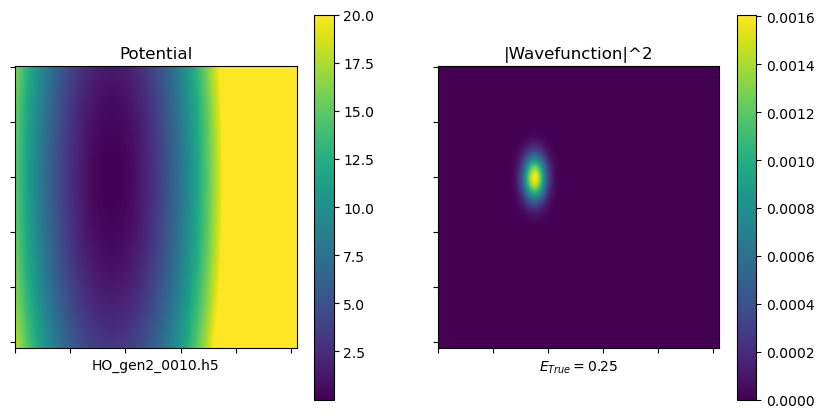

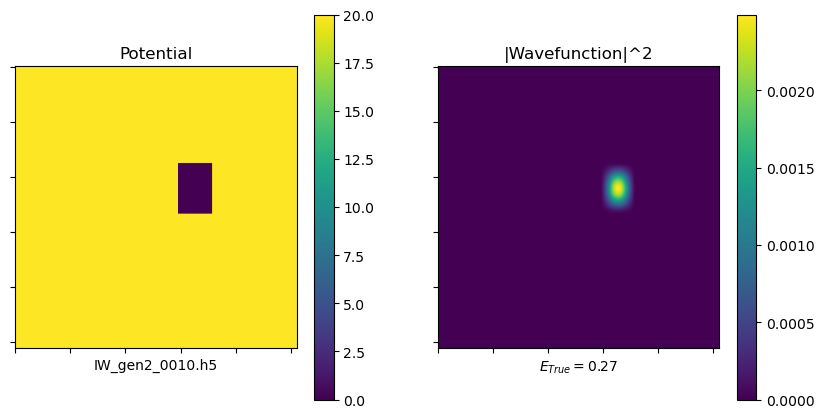

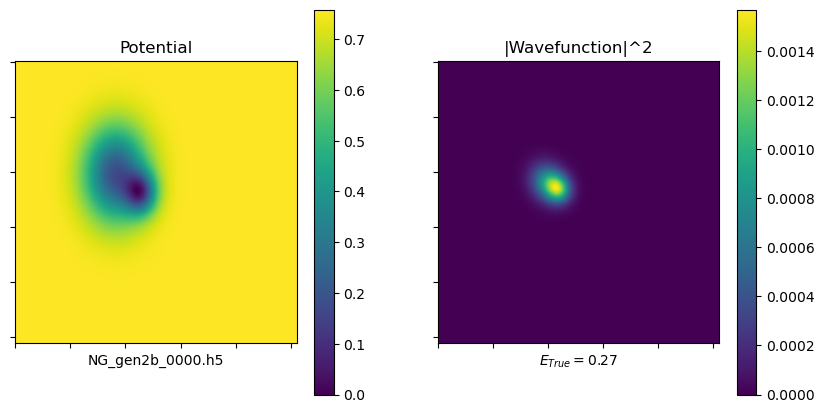

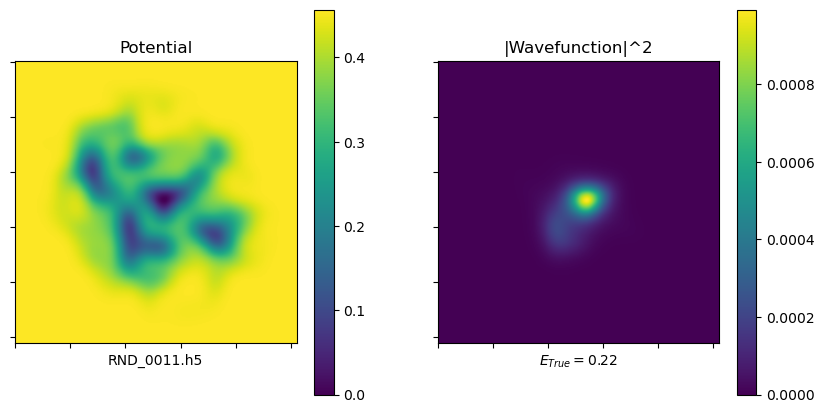

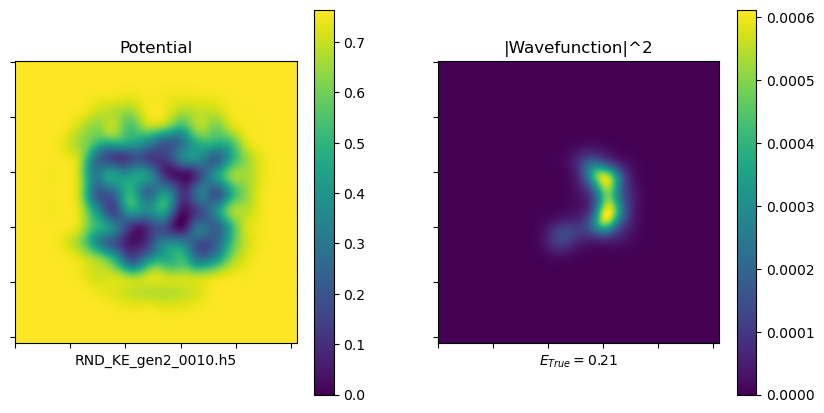

In [3]:
sample_idx = [0,5000,10000,15000,20000] if potential_type == 'all' else [0]
for idx in sample_idx:
    potential = dset[idx]['potential']
    wavefunction2 = dset[idx]['wavefunction2']
    energy = dset[idx]['energy']
    potential_label = dset[idx]['potential_label']
    print_img(potential,wavefunction2,'Potential','|Wavefunction|^2',energy,potential_label)

## Split Data

In [4]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

seed = 12

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

train_generator = torch.Generator()
train_generator.manual_seed(seed)

val_generator = torch.Generator()
val_generator.manual_seed(seed)

test_generator = torch.Generator()
test_generator.manual_seed(seed)

train_dataset, test_dataset = train_test_split(dset, test_size=0.2, shuffle=True,random_state=seed)
train_dataset, validation_dataset = train_test_split(train_dataset, test_size=0.2, shuffle=True,random_state=seed)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True,generator=train_generator)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True,generator=val_generator)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True,generator=test_generator)

# Part 1

## Create Model

In [5]:
from torch import nn
import math

class EnergyCNN(nn.Module):
    def __init__(self, cnn_channels:tuple,hidden_layers:tuple=()):
        '''
        Model for predicting energy of a wavefunction using a potential map
        :param cnn_channels: Tuple of tuples containing parameters for each CNN layer
        :param hidden_layers: Tuple containing ints describing output for each hidden layer
        '''
        super().__init__()

        cnn_layers = []
        if cnn_channels:
            cnn_layers.append(nn.Conv2d(1,cnn_channels[0][0],cnn_channels[0][1],stride=cnn_channels[0][2],padding=cnn_channels[0][3], padding_mode='replicate'))
            cnn_layers.append(nn.ReLU())
            for i in range(len(cnn_channels)-1):
                cnn_layers.append(nn.Conv2d(cnn_channels[i][0],cnn_channels[i+1][0],cnn_channels[i+1][1],stride=cnn_channels[i+1][2],padding=cnn_channels[i+1][3], padding_mode='replicate'))
                cnn_layers.append(nn.ReLU())

        self.cnn_stack = nn.Sequential(*cnn_layers)
        cnn_output = self.cnn_stack(torch.zeros(1,256,256))

        linear_layers = []
        if hidden_layers:
            linear_layers.append(nn.Flatten())
            linear_layers.append(nn.Linear(cnn_output.numel(),hidden_layers[0]))
            linear_layers.append(nn.ReLU())
            for i in range(len(hidden_layers)-1):
                linear_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
                linear_layers.append(nn.ReLU())
            linear_layers.append(nn.Linear(hidden_layers[-1], 1))
        else:
            linear_layers.append(nn.Linear(math.prod(cnn_output),1))
        self.linear_stack = nn.Sequential(*linear_layers)

    def forward(self,X:Tensor)->Tensor:
        '''
        Predicts energy for the wavefunction
        :param X: Potential image
        :return: Energy prediction
        '''
        X = self.linear_stack(self.cnn_stack(X))
        return X

## Train Model

In [6]:
from tqdm.notebook import tqdm

def energy_test(model:nn.Module,
                dataloader:DataLoader,
                loss_fn:nn.Module,
                device:str,
                validate:bool=False)->None:
    '''
    Testing loop for the EnergyCNN
    :param model: Model used for testing
    :param dataloader: DataLoader containing validate or test data
    :param loss_fn: Loss function used in training
    :param device: CPU or CUDA
    :param validate: True for validation tests else False
    :return: None
    '''
    model.eval()
    losses = []
    with torch.inference_mode():
        for data in dataloader:
            X = data['potential'].to(device)
            y = data['energy'].to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            losses.append(loss.item())
        average_loss = sum(losses) / len(losses)
        test_type = 'Validation' if validate else 'Test'
        tqdm.write(f'{test_type} Loss: {average_loss}\n')

In [7]:
from torch.optim import Optimizer

def energy_train(model:nn.Module,
                 epochs:int,
                 train_dataloader:DataLoader,
                 validation_dataloader:DataLoader,
                 optimizer:Optimizer,
                 loss_fn:nn.Module,
                 device='cuda')->None:
    '''
    Training loop for the EnergyCNN
    :param model: Model used for training
    :param epochs: Number of cycles
    :param train_dataloader: Dataloader containing training data
    :param validation_dataloader: Dataloader containing validation data
    :param optimizer: Optimizer used for training
    :param loss_fn: Loss function used in training
    :param device: CPU or CUDA
    :return: None
    '''
    for epoch in tqdm(range(epochs),unit='epochs',position=0):
        model.train()
        losses = []
        for data in tqdm(train_dataloader,unit='batches',leave=False,position=1):
            optimizer.zero_grad()
            X = data['potential'].to(device)
            y = data['energy'].to(device)

            loss = loss_fn(model(X), y)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        avg_loss = sum(losses) / len(losses)

        tqdm.write(f'Epoch {epoch + 1}/{epochs}\nTrain Loss: {avg_loss}')

        energy_test(model,validation_dataloader,loss_fn,device,validate=True)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EnergyCNN(cnn_channels=((64,3,2,1),
                                (16,3,2,1),
                                (64,3,2,1),
                                (16,3,2,1)),
                  hidden_layers=(64,),
                  ).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

epochs = 10
energy_train(model,epochs,train_dataloader,validation_dataloader,optimizer,loss_fn,device)
energy_test(model,test_dataloader,loss_fn,device,validate=False)


  0%|          | 0/1 [00:00<?, ?epochs/s]

  0%|          | 0/1000 [00:00<?, ?batches/s]

Epoch 1/1
Train Loss: 0.005741666515241377
Validation Loss: 0.004284974432550371

Test Loss: 0.004258828282470818



## Results

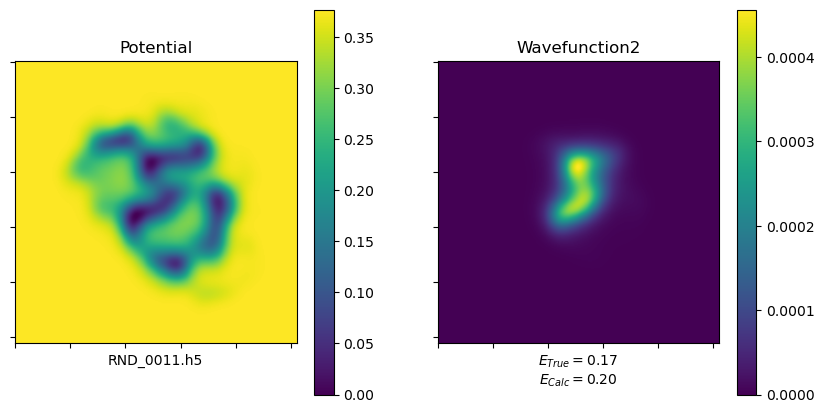

In [9]:
presentation_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

limit = 1
model.eval()
for i, data in enumerate(presentation_dataloader):
    if i >= limit:
        break

    potential = data['potential']
    wavefunction2 = data['wavefunction2']
    energy = data['energy']
    potential_label = data['potential_label']
    with torch.inference_mode():
        energy_pred = model.forward(potential.to(device))
        print_img(potential.squeeze(dim=0),wavefunction2.squeeze(dim=0),'Potential','Wavefunction2',energy,potential_label,energy_pred)

In [10]:
#torch.save(model2.state_dict(), 'Data/Models/model_state_dict.pt')